We conduct analysis to the market price data and fit the marginal distributions (t-distributions)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import t, norm
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf
import random
from scipy import optimize
import math

First step is to load the data. The optimization will include only those companies with available emissions data, this is why the emissions data is loaded first, and then used to filter down the market price data of the companies.

In [2]:
folderpath = "Data/Simulations/OPTIMIZATION 2005-2019"
included_countries = ["Austria", "Belgium", "Denmark", "Finland", "France", "Germany", "Italy", "Netherlands", "Norway", "Sweden", "Switzerland", "United Kingdom of Great Britain and Northern Ireland", "United States of America"]

financed_emissions = pd.read_csv("Data/Emissions/FinancedEmissions2020.csv", sep=";", header=None, decimal=",")
financed_emissions.columns = ["Ticker", "Country", "Company Name", "CDP Score", "Industry", "CE (tCO2e)", "Estimated EVIC (MEUR)", "Emission intensity (tCO2e/MEUR)"]
financed_emissions = financed_emissions[financed_emissions["Country"].isin(included_countries)].set_index("Ticker")
financed_emissions

,Country,Company Name,CDP Score,Industry,CE (tCO2e),Estimated EVIC (MEUR),Emission intensity (tCO2e/MEUR)
Ticker,,,,,,,
AGR.VI,Austria,AGRANA Beteiligungs-AG,3.0,"Food, beverage & agriculture",381000.0,2035.221761,187.203187
ANDR.VI,Austria,ANDRITZ AG,4.5,Manufacturing,222452.0,3354.578799,66.312945
CAI.VI,Austria,CA Immobilien Anlagen AG,7.0,Infrastructure,50945.0,4327.273630,11.773002
EBS.VI,Austria,Erste Group Bank AG,5.5,Services,71950.0,63710.792646,1.129322
EVN.VI,Austria,EVN AG,5.0,Infrastructure,3050754.0,6717.123518,454.175659
...,...,...,...,...,...,...,...
WRB,United States of America,W.R. Berkley Corp.,4.0,Services,12000.0,8026.036944,1.495134
WTI,United States of America,W & T Offshore,6.0,Fossil Fuels,975000.0,730.149131,1335.343643
WTRG,United States of America,"Essential Utilities, Inc",6.0,Infrastructure,146057.0,7377.655394,19.797211


In [3]:
pd.read_csv("Data/Market price data/STOCK_PRICE_EUR_NOTNULL.csv", index_col=0).transpose()

,AGR.VI,ANDR.VI,CAI.VI,DOC.VI,EBS.VI,EVN.VI,FLU.VI,IIA.VI,LNZ.VI,MMK.VI,...,ZBRA,ZBH,ZION,^GSPC,^FCHI,^OMX,^OMXH25,^GDAXI,^FTSE,^SSMI
2005-1,10.413229,4.314121,11.377453,6.848340,23.324680,8.013043,7.343184,36.729477,16.030319,39.844101,...,39.021040,53.340199,37.988980,905.053692,3913.689941,NaN,NaN,4254.850098,7007.943320,3723.243673
2005-2,10.140198,4.720487,11.439225,6.846281,25.355593,8.994070,7.801718,36.781204,16.681293,42.392380,...,37.731641,57.383537,36.752065,910.643736,4027.159912,NaN,NaN,4350.490234,7215.364469,3855.749633
2005-3,9.632235,4.915369,11.422379,7.412515,24.832478,8.526537,6.885981,36.367348,16.803358,38.726276,...,36.623813,52.981525,39.115624,910.459129,4067.780029,NaN,NaN,4348.770020,7134.693844,3824.625983
2005-4,9.194118,4.383574,11.484156,7.618420,23.072359,8.257110,6.965073,36.730648,15.704832,36.449554,...,37.092324,55.831409,39.968500,898.455939,3911.709961,NaN,NaN,4184.839844,7119.959067,3815.924596
2005-5,9.238566,5.168197,11.456975,7.515469,24.935123,8.905316,7.201622,38.187389,15.623459,37.036049,...,34.579149,54.935838,42.515235,968.069898,4120.729980,NaN,NaN,4460.629883,7332.348747,3991.401382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-1,16.500000,53.053719,27.500000,97.099998,32.631779,18.353767,34.049999,12.390000,64.900002,149.369553,...,291.391488,117.133006,47.772486,3756.994742,7082.419922,194.950802,4938.439941,15128.269530,8846.456170,11241.152591
2023-2,17.000000,56.587406,25.961538,107.400002,34.913654,20.750000,34.250000,12.310000,71.800003,154.419754,...,282.955609,116.512738,46.881108,3741.469385,7267.930176,202.128617,5027.020020,15365.139650,8955.021455,11180.638906
2023-3,16.350000,62.299999,23.846153,107.599998,28.640841,20.450001,39.500000,12.930000,69.500000,148.592590,...,291.618727,118.481568,26.973384,3768.401782,7322.390137,196.925355,4777.660156,15628.839840,8670.021806,11150.843695
2023-4,17.049999,58.849998,25.288460,106.199997,30.903936,21.850000,40.200001,14.820000,59.299999,140.434570,...,261.084784,125.488936,24.817922,3779.425003,7491.500000,200.095538,4749.990234,15922.379880,8916.708329,11598.121747


In [4]:
stock_price_data = pd.read_csv("Data/Market price data/STOCK_PRICE_EUR_NOTNULL.csv", index_col=0).transpose()
index_tickers = ['^GSPC', '^FCHI', '^OMX', '^OMXH25', '^GDAXI', '^FTSE', '^SSMI']
filtered_ticker_list = financed_emissions.index.union(pd.Index(index_tickers), sort=False) # Indices are also included
dataframe = stock_price_data.loc[:,filtered_ticker_list]
dataframe

,AGR.VI,ANDR.VI,CAI.VI,EBS.VI,EVN.VI,FLU.VI,IIA.VI,LNZ.VI,OMV.VI,PAL.VI,...,WTRG,WYNN,X,^GSPC,^FCHI,^OMX,^OMXH25,^GDAXI,^FTSE,^SSMI
2005-1,10.413229,4.314121,11.377453,23.324680,8.013043,7.343184,36.729477,16.030319,11.533068,7.012344,...,7.009663,27.655885,33.745487,905.053692,3913.689941,NaN,NaN,4254.850098,7007.943320,3723.243673
2005-2,10.140198,4.720487,11.439225,25.355593,8.994070,7.801718,36.781204,16.681293,12.628925,7.390419,...,7.118202,29.814038,40.178278,910.643736,4027.159912,NaN,NaN,4350.490234,7215.364469,3855.749633
2005-3,9.632235,4.915369,11.422379,24.832478,8.526537,6.885981,36.367348,16.803358,11.832376,7.157382,...,7.190528,28.762734,33.394210,910.459129,4067.780029,NaN,NaN,4348.770020,7134.693844,3824.625983
2005-4,9.194118,4.383574,11.484156,23.072359,8.257110,6.965073,36.730648,15.704832,11.537893,6.897115,...,7.936940,22.637434,28.279805,898.455939,3911.709961,NaN,NaN,4184.839844,7119.959067,3815.924596
2005-5,9.238566,5.168197,11.456975,24.935123,8.905316,7.201622,38.187389,15.623459,13.998711,7.845218,...,8.507575,20.957805,27.589163,968.069898,4120.729980,NaN,NaN,4460.629883,7332.348747,3991.401382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-1,16.500000,53.053719,27.500000,32.631779,18.353767,34.049999,12.390000,64.900002,45.849998,27.055443,...,42.513153,95.298098,26.147142,3756.994742,7082.419922,194.950802,4938.439941,15128.269530,8846.456170,11241.152591
2023-2,17.000000,56.587406,25.961538,34.913654,20.750000,34.250000,12.310000,71.800003,46.110001,30.656347,...,40.046602,101.896378,28.796852,3741.469385,7267.930176,202.128617,5027.020020,15365.139650,8955.021455,11180.638906
2023-3,16.350000,62.299999,23.846153,28.640841,20.450001,39.500000,12.930000,69.500000,42.259998,27.980000,...,39.761443,102.393306,23.877649,3768.401782,7322.390137,196.925355,4777.660156,15628.839840,8670.021806,11150.843695
2023-4,17.049999,58.849998,25.288460,30.903936,21.850000,40.200001,14.820000,59.299999,42.840000,29.850000,...,38.446900,103.354273,20.690100,3779.425003,7491.500000,200.095538,4749.990234,15922.379880,8916.708329,11598.121747


There are some negative values in the price data (adjusted closing price has been used). All assets containing negative values are removed to make it possible to calculate the log-difference.

Returns are modeled by log-differences; first we take a logarithm of each price, then a first-order difference.

In [5]:
neg_column_indices = np.unique(np.where(dataframe<0)[1])
drop_neg = dataframe.drop(dataframe.columns[neg_column_indices], axis=1)
log_prices = np.log(drop_neg).dropna(axis=1)
filtered_ticker_list2 = log_prices.columns[:-5]
log_prices # logarithmic market prices

,AGR.VI,ANDR.VI,CAI.VI,EBS.VI,EVN.VI,FLU.VI,IIA.VI,LNZ.VI,OMV.VI,PAL.VI,...,WRB,WTI,WTRG,WYNN,X,^GSPC,^FCHI,^GDAXI,^FTSE,^SSMI
2005-1,2.343077,1.461894,2.431634,3.149512,2.081071,1.993772,3.603580,2.774482,2.445218,1.947672,...,1.681329,2.352918,1.947290,3.319839,3.518847,6.807994,8.272236,8.355815,8.854800,8.222351
2005-2,2.316508,1.551912,2.437048,3.232999,2.196565,2.054344,3.604987,2.814288,2.535990,2.000184,...,1.742687,2.429647,1.962655,3.394979,3.693327,6.814152,8.300817,8.378044,8.883968,8.257321
2005-3,2.265115,1.592367,2.435574,3.212152,2.143183,1.929488,3.593671,2.821579,2.470839,1.968144,...,1.728407,2.491055,1.972765,3.359081,3.508383,6.813949,8.310853,8.377648,8.872725,8.249216
2005-4,2.218564,1.477864,2.440968,3.138635,2.111075,1.940908,3.603612,2.753968,2.445637,1.931103,...,1.718164,2.464237,2.071528,3.119605,3.342148,6.800678,8.271730,8.339224,8.870657,8.246938
2005-5,2.223387,1.642524,2.438599,3.216277,2.186648,1.974306,3.642505,2.748774,2.638965,2.059904,...,1.850444,2.581962,2.140957,3.042511,3.317423,6.875304,8.323786,8.403045,8.900051,8.291898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-1,2.803360,3.971305,3.314186,3.485287,2.909835,3.527830,2.516890,4.172848,3.825375,3.297888,...,4.167334,1.746126,3.749814,4.557010,3.263740,8.231375,8.865371,9.624320,9.087772,9.327337
2023-2,2.833213,4.035786,3.256616,3.552878,3.032546,3.533687,2.510412,4.273885,3.831030,3.422840,...,4.131688,1.665225,3.690044,4.623956,3.360266,8.227234,8.891227,9.639857,9.099970,9.321939
2023-3,2.794228,4.131961,3.171623,3.354834,3.017983,3.676301,2.559550,4.241327,3.743841,3.331490,...,4.044715,1.538707,3.682898,4.628821,3.172943,8.234406,8.898692,9.656873,9.067627,9.319270
2023-4,2.836150,4.074992,3.230348,3.430884,3.084201,3.693867,2.695978,4.082609,3.757472,3.396185,...,3.977961,1.376544,3.649278,4.638163,3.029655,8.237327,8.921524,9.675481,9.095682,9.358598


In [6]:
t0 = 180 # start of the optimization period
opt_period = 41 # length (months) of the optimization period
t_start = 1 # first data value
period = 1 # difference taken for

logdiff = log_prices.diff(period).iloc[t_start:t0,:] # will be used for fitting
exp_returns = np.exp(log_prices.diff(period)).iloc[t0-1:t0+opt_period,:]
exp_returns.iloc[0,:] = exp_returns.iloc[0,:] / exp_returns.iloc[0,:]
exp_returns.to_csv(f"{folderpath}/Actual_exp_returns2.csv", sep=";")
filtered_ticker_list = pd.DataFrame(logdiff.columns, columns=["Ticker"])
# logdiff.to_csv(f"{folderpath}/Log_returns_empirical.csv")
logdiff

,AGR.VI,ANDR.VI,CAI.VI,EBS.VI,EVN.VI,FLU.VI,IIA.VI,LNZ.VI,OMV.VI,PAL.VI,...,WRB,WTI,WTRG,WYNN,X,^GSPC,^FCHI,^GDAXI,^FTSE,^SSMI
2005-2,-0.026570,0.090018,0.005415,0.083487,0.115495,0.060571,0.001407,0.039806,0.090771,0.052512,...,0.061358,0.076729,0.015366,0.075141,0.174480,0.006157,0.028581,0.022229,0.029168,0.034970
2005-3,-0.051392,0.040455,-0.001474,-0.020847,-0.053382,-0.124856,-0.011316,0.007291,-0.065150,-0.032040,...,-0.014280,0.061408,0.010109,-0.035899,-0.184944,-0.000203,0.010036,-0.000395,-0.011243,-0.008105
2005-4,-0.046551,-0.114502,0.005394,-0.073517,-0.032109,0.011420,0.009940,-0.067610,-0.025203,-0.037041,...,-0.010244,-0.026818,0.098763,-0.239476,-0.166235,-0.013271,-0.039123,-0.038425,-0.002067,-0.002278
2005-5,0.004823,0.164660,-0.002370,0.077642,0.075574,0.033398,0.038894,-0.005195,0.193329,0.128801,...,0.132280,0.117725,0.069429,-0.077094,-0.024725,0.074627,0.052056,0.063822,0.029394,0.044959
2005-6,0.029125,0.106842,0.002450,0.034427,0.062100,0.029152,0.030854,0.002992,0.233587,0.153542,...,0.025379,0.127912,0.106327,0.026711,-0.128143,0.017643,0.026018,0.027779,0.032572,0.010035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-8,-0.081580,-0.009938,0.012500,-0.102829,0.064625,-0.071227,0.050993,-0.071982,0.023987,-0.034786,...,0.035096,-0.016161,0.068350,-0.147955,-0.292876,-0.009614,-0.006986,-0.020703,-0.040457,0.010474
2019-9,0.057089,0.157356,0.010811,0.035904,0.050837,0.029103,0.004118,0.029870,0.059191,0.066334,...,0.026026,0.008551,0.022956,-0.002230,0.053284,0.027872,0.035369,0.040125,0.046968,0.023782
2019-10,0.019872,0.071514,0.061076,0.042903,0.014760,-0.041257,0.007797,0.065705,0.060672,0.058308,...,-0.051958,-0.100165,-0.008077,0.090652,-0.022637,0.001058,0.009129,0.034691,0.007402,-0.003092
2019-11,0.058444,-0.129143,0.073798,0.025870,0.006086,0.021506,-0.047723,-0.066271,-0.011148,0.093177,...,-0.002268,0.073065,-0.005402,0.017148,0.147429,0.046358,0.030137,0.028320,0.027048,0.029717


#### Emission intensity methodology comparison

We compare the emission intensity (at 2019 year-end) denominated by an EVIC estimate (used in the study, includes current debt, long term debt, common equity and minorities' interest), and that by revenue (provided by CDP, converted to EUR using the exchange rate of Dec 2019). Unit is tCO2e/EUR. We see similar magnitudes but the differences could be researched further.

In [13]:
cdp_intensity = pd.read_csv("Data/Emissions/CDP_GHG_Intensity_2020.csv", index_col=0, header=None, sep=";", decimal=",")
emission_intensities = financed_emissions.copy()
emission_intensities = emission_intensities[emission_intensities["Company Name"]!="Sweco AB"]
emission_intensities["CDP emission intensity"] = cdp_intensity.loc[filtered_ticker_list2, :]
emission_intensities_by_industry = pd.concat([emission_intensities.loc[:, ["Industry", "Emission intensity (tCO2e/MEUR)"]].groupby("Industry").mean(), emission_intensities.loc[:, ["Industry", "Emission intensity (tCO2e/MEUR)"]].groupby("Industry").median(), emission_intensities.loc[:, ["Industry", "CDP emission intensity"]].groupby("Industry").mean()/1.11823, emission_intensities.loc[:, ["Industry", "CDP emission intensity"]].groupby("Industry").median()/1.11823], axis=1)
emission_intensities_by_industry.columns=["Mean (EVIC-based)", "Median (EVIC-based)", "Mean (Revenue-based)", "Median (Revenue-based)"]
emission_intensities_by_industry

,Mean (EVIC-based),Median (EVIC-based),Mean (Revenue-based),Median (Revenue-based)
Industry,,,,
Apparel,328.344964,328.344964,187.912945,187.912945
"Biotech, health care & pharma",31.319132,21.700679,34.016793,34.332805
"Food, beverage & agriculture",105.254253,63.345174,91.947668,53.250352
Fossil Fuels,1246.078761,367.582686,1056.486046,478.893141
Hospitality,136.795626,44.797494,84.845628,29.076651
Infrastructure,194.987305,20.139045,324.253181,36.174694
Manufacturing,82.608022,41.690784,50.031115,24.130733
Materials,686.742943,323.974377,682.575084,275.506862
Power generation,835.136959,513.310972,2524.428468,1088.896893


In [15]:
emission_intensities[emission_intensities["Company Name"]!="Sweco AB"]["CDP emission intensity"].median()

27.3448636678401

## Distributions and analysis of individual series

Iterate through each asset and for each
- Fit a (location-scale) t-distribution to each series and store the parameters
- Compute goodness of fit using the Kolmogorov-Smirnov test
- Use the CDF of the fitted distribution to perform a probability integral transform (PIT) and store the pseudo-uniform series
- Also fit a normal distribution and perform the KS test for comparison

In [10]:
distribution_stats = pd.DataFrame(np.zeros((logdiff.shape[1], 4)), columns=['KS p-value','DoF','Location','Scale'], index=logdiff.columns) # initialize a dataframe of fit statistics

pit = logdiff.copy()

for ticker in logdiff:
    log_returns = logdiff[ticker]
    df, loc, scale = t.fit(log_returns)

    t_distr = t.cdf(log_returns,df,loc,scale)
    pit[ticker] = t_distr

    ecdf = ECDF(log_returns)
    ks_result = stats.kstest(ecdf.y, t_distr)

    distribution_stats.loc[ticker,:] = [ks_result.pvalue, df, loc, scale]
pit.to_csv(f"{folderpath}/PIT_SERIES.csv")

Add further descriptive statistics (moments) of the return series:

In [12]:
company_stats = distribution_stats.copy()
company_stats.insert(3, "Mean", logdiff.mean())
company_stats.insert(4, "Difference", company_stats["Location"]-company_stats["Mean"])
company_stats.insert(6, "St. Dev.", logdiff.describe().loc["std",:])
company_stats.insert(7, "Skewness", stats.skew(logdiff))
company_stats.insert(8, "Kurtosis", stats.kurtosis(logdiff))
company_stats.to_csv(f"{folderpath}/COMPANY_SUMMARY.csv")
company_stats.sort_values("Difference")

,KS p-value,DoF,Location,Mean,Difference,Scale,St. Dev.,Skewness,Kurtosis
PRC.PA,0.983844,2.109379,-0.017363,0.006556,-0.023919,0.085634,0.187197,2.438550,11.595498
FING-B.ST,0.997116,3.296553,-0.009931,0.010883,-0.020815,0.170300,0.247092,0.442052,1.604907
COX.PA,0.999946,2.363519,-0.023208,-0.008192,-0.015015,0.091634,0.182317,1.507544,13.354154
PHARM.AS,0.990908,2.362151,-0.030191,-0.016979,-0.013212,0.109996,0.196239,0.424267,4.215973
CLA.PA,0.990236,2.219487,-0.021946,-0.011109,-0.010836,0.096992,0.185461,0.804970,5.426574
...,...,...,...,...,...,...,...,...,...
SDY.L,0.996183,2.581386,0.011273,-0.004663,0.015936,0.087227,0.149729,-0.548900,4.325375
WKP.L,0.965596,2.303660,0.017573,-0.000939,0.018512,0.059620,0.128521,-3.291102,20.306458
DOF.OL,0.921080,3.042034,-0.005103,-0.025798,0.020695,0.103112,0.174928,-2.488618,14.574483
TW.L,0.858539,2.055126,0.021834,0.000112,0.021723,0.069629,0.165334,-2.304163,21.048207


Visualizations of the fit statistics

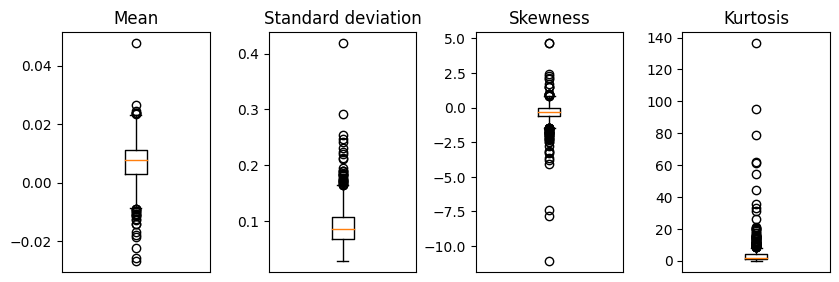

In [11]:
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4)
ax1.boxplot(company_stats["Mean"])
ax1.set_title("Mean"); ax1.set_xticks([])
ax2.boxplot(company_stats["St. Dev."]); ax2.set_xticks([])
ax2.set_title("Standard deviation")
ax3.boxplot(company_stats["Skewness"]); ax3.set_xticks([])
ax3.set_title("Skewness")
ax4.boxplot(company_stats["Kurtosis"]); ax4.set_xticks([])
ax4.set_title("Kurtosis")

plt.subplots_adjust(left=0,
                bottom=0.1,
                right=1.2,
                top=0.6,
                wspace=0.4,
                hspace=0.3)
plt.savefig("Pictures/series_statistics.png", dpi=300, bbox_inches='tight')
plt.show()

We take a further look at individual series

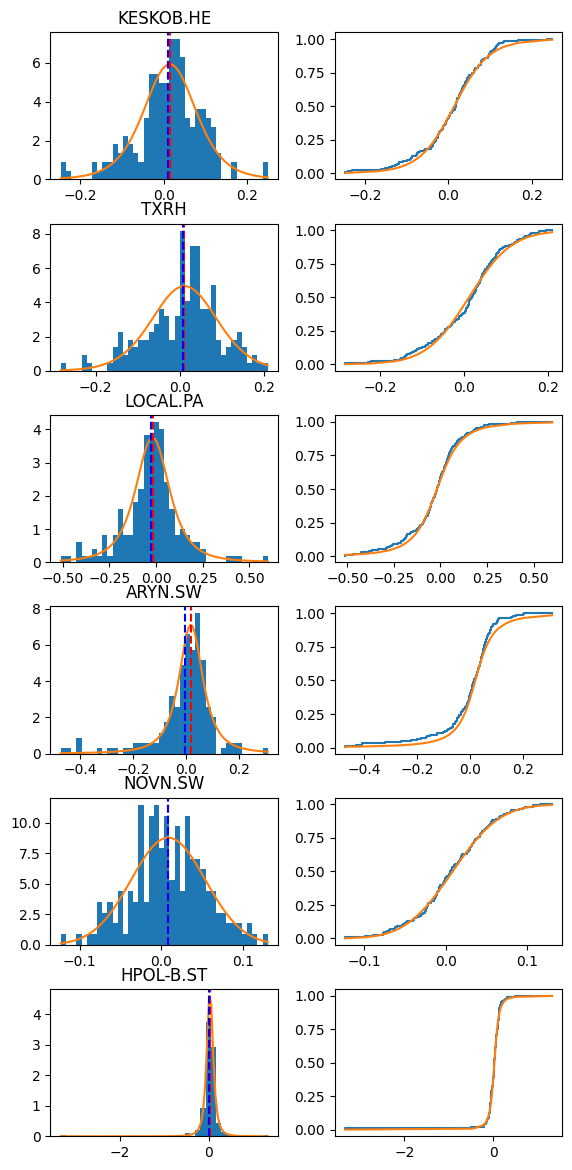

In [12]:
# Visual inspection of individual companies
tickers = ["KESKOB.HE", "TXRH", "LOCAL.PA", "ARYN.SW", "NOVN.SW", "HPOL-B.ST"] # can be replaced with arbitrary tickers in data

fig, ax = plt.subplots(len(tickers),2)
axislist = ax.flatten()

for i in range(len(tickers)):
    ax_1 = axislist[2*i]; ax_2 = axislist[2*i+1]
    ticker = tickers[i]
    log_returns = logdiff[ticker]

    # Plot the fitted distribution, along with the means
    ics = company_stats.loc[ticker,:]

    ax_1.hist(log_returns, bins=40, density=True)
    xmin, xmax = (log_returns.min(), log_returns.max()); x = np.linspace(xmin, xmax, 100)
    ax_1.plot(x, t.pdf(x, df=ics["DoF"], loc=ics["Location"], scale=ics["Scale"]))
    ax_1.axvline(ics["Location"], color='red', linestyle="dashed"); ax_1.axvline(ics["Mean"], color='blue', linestyle='dashed')
    ax_1.set_title(ticker)

    # Plot the empirical and fitted CDF
    t_distr = np.sort(t.cdf(log_returns, df=ics["DoF"], loc=ics["Location"], scale=ics["Scale"]))
    ecdf = ECDF(log_returns)
    ks_result = stats.kstest(ecdf.y, t_distr)
    ax_2.step(ecdf.x, ecdf.y)
    ax_2.plot(ecdf.x[1:], t_distr)

plt.subplots_adjust(left=0,
                    bottom=0.1,
                    right=0.8,
                    top=2.4,
                    wspace=0.25,
                    hspace=0.3)
#fig.legend(['Fitted PDF','PDF location','Data mean','Data distribution','ECDF','Fitted CDF'], loc=[0.75,0.7])
plt.show()

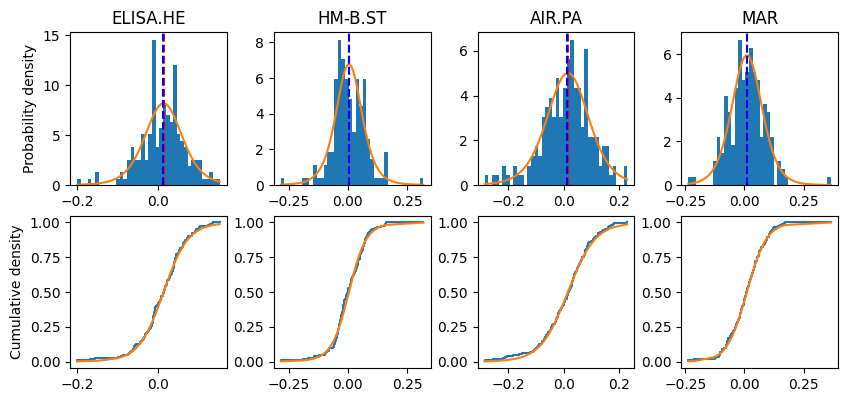

In [13]:
tickers = ["ELISA.HE", "HM-B.ST", "AIR.PA", "MAR"]

fig, ax = plt.subplots(2, len(tickers))
axislist = ax.flatten()

for i in range(len(tickers)):
    ax_1 = axislist[i]; ax_2 = axislist[i+len(tickers)]
    ticker = tickers[i]
    log_returns = logdiff[ticker]

    # Plot the fitted distribution, along with the means
    ics = company_stats.loc[ticker,:]

    ax_1.hist(log_returns, bins=40, density=True)
    xmin, xmax = (log_returns.min(), log_returns.max()); x = np.linspace(xmin, xmax, 100)
    ax_1.plot(x, t.pdf(x, df=ics["DoF"], loc=ics["Location"], scale=ics["Scale"]))
    ax_1.axvline(ics["Location"], color='red', linestyle="dashed"); ax_1.axvline(ics["Mean"], color='blue', linestyle='dashed')
    ax_1.set_title(ticker)

    # Plot the empirical and fitted CDF
    t_distr = np.sort(t.cdf(log_returns, df=ics["DoF"], loc=ics["Location"], scale=ics["Scale"]))
    ecdf = ECDF(log_returns)
    ks_result = stats.kstest(ecdf.y, t_distr)
    ax_2.step(ecdf.x, ecdf.y)
    ax_2.plot(ecdf.x[1:], t_distr)

axislist[0].set_ylabel("Probability density")
axislist[len(tickers)].set_ylabel("Cumulative density")
plt.subplots_adjust(left=0,
                    bottom=0.1,
                    right=1.2,
                    top=0.8,
                    wspace=0.3,
                    hspace=0.2)
#fig.legend(['Fitted PDF','PDF location','Data mean','Data distribution','ECDF','Fitted CDF'], loc=[0.75,0.7])
plt.savefig("Pictures/return_distributions.png", dpi=300, bbox_inches = 'tight')
plt.show()

Visual inspection of the PIT transformed series (should approximately follow the standard uniform distribution)

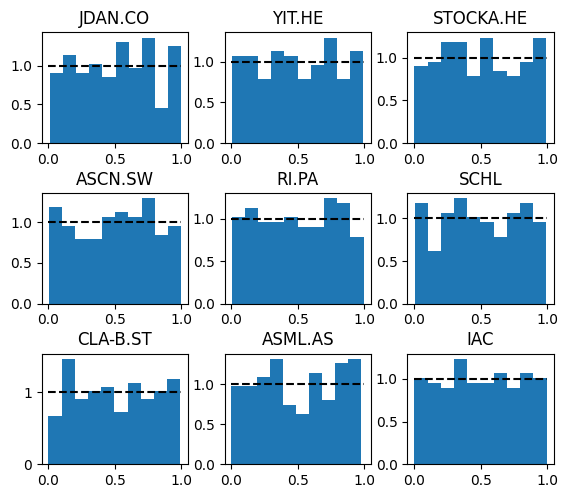

In [14]:
plot_count = 9
ncolumns = 3
seed = 2

fig, ax = plt.subplots(math.ceil(plot_count / ncolumns), ncolumns)
axislist = ax.flatten()
n = len(pit.transpose())
random.seed(seed)

for i in range(plot_count):
    ticker_index = random.randint(0,n)
    ticker = pit.columns[ticker_index]
    ax_i = axislist[i]
    ax_i.hist(pit[ticker],density=True)
    ax_i.hlines(1,0,1,linestyles="--",colors="black")
    ax_i.set_title(ticker)

plt.subplots_adjust(left=0,
                bottom=0.1,
                right=0.8,
                top=1,
                wspace=0.25,
                hspace=0.45)

plt.show()

There's some variation in how well the transformed series approximate a uniform distribution, but overall the quality of the fit seems decent. Next we plot the distribution of the parameter estimators and print a summary of the distribution of the statistics.

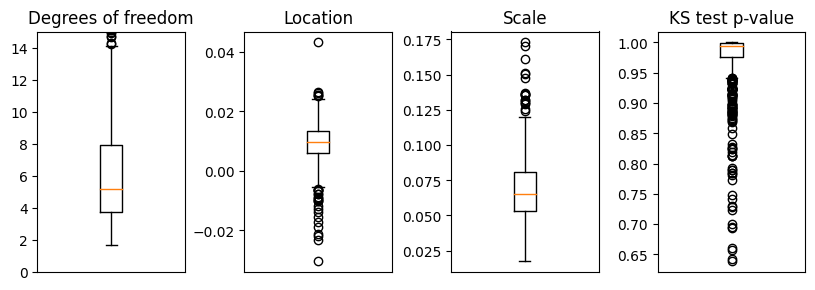

,KS p-value,DoF,Location,Mean,Difference,Scale,St. Dev.,Skewness,Kurtosis
count,729.000000,7.290000e+02,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000
mean,0.973213,5.617292e+04,0.009217,0.006935,0.002282,0.068712,0.092773,-0.406191,3.895395
std,0.053414,4.876947e+05,0.007079,0.006951,0.004108,0.021424,0.036149,0.900539,8.682674
min,0.639833,1.681843e+00,-0.030191,-0.026869,-0.023919,0.017979,0.029033,-11.083200,-0.348127
25%,0.976254,3.712072e+00,0.005870,0.003064,0.000230,0.053395,0.069161,-0.618095,0.905342
50%,0.994464,5.152388e+00,0.009707,0.007704,0.001964,0.065391,0.086776,-0.337651,1.894866
75%,0.999206,7.882107e+00,0.013370,0.011059,0.004022,0.080734,0.107774,-0.041060,3.850985
max,1.000000,8.985447e+06,0.043198,0.047727,0.022931,0.172781,0.418970,4.661206,136.673586


In [15]:
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4)
ax1.boxplot(company_stats["DoF"])
ax1.set_title("Degrees of freedom"); ax1.set_xticks([])
ax1.set_ylim((0,15))
ax2.boxplot(company_stats["Location"]); ax2.set_xticks([])
ax2.set_title("Location")
ax3.boxplot(company_stats["Scale"]); ax3.set_xticks([])
ax3.set_title("Scale")
ax4.boxplot(company_stats["KS p-value"]); ax4.set_xticks([])
ax4.set_title("KS test p-value")

plt.subplots_adjust(left=0,
                bottom=0.1,
                right=1.2,
                top=0.6,
                wspace=0.4,
                hspace=0.3)
# plt.savefig("Pictures/fit_statistics.png", dpi=300, bbox_inches='tight')
plt.show()
company_stats.describe()

In [13]:
company_stats.sort_values("DoF")

,KS p-value,DoF,Location,Mean,Difference,Scale,St. Dev.,Skewness,Kurtosis
CPHN.SW,0.998598,1.681843e+00,-0.002981,0.002868,-5.849631e-03,0.031924,0.071865,0.854290,3.017101
JUVE.MI,0.961158,1.749762e+00,-0.003366,0.005472,-8.838220e-03,0.061650,0.142473,-0.557430,6.184682
KBHL.CO,0.812557,1.788698e+00,0.004028,0.012396,-8.367803e-03,0.031466,0.066511,0.536296,2.675376
IIA.VI,0.999730,1.799331e+00,0.007320,-0.002758,1.007736e-02,0.052743,0.161793,-2.771538,19.614489
TYMN.L,0.886295,1.817443e+00,0.010741,0.010626,1.148697e-04,0.057983,0.139238,0.858255,10.953583
...,...,...,...,...,...,...,...,...,...
COST,0.983601,2.810707e+06,0.012809,0.012808,2.506042e-07,0.055989,0.056145,-0.236008,-0.109884
SO,0.992853,4.099555e+06,0.008297,0.008297,7.228883e-07,0.045368,0.045496,-0.196233,-0.348127
RUI.PA,0.991903,4.361429e+06,0.012778,0.012778,-8.691594e-07,0.057955,0.058117,-0.013481,-0.100322
ADI,0.999537,4.770638e+06,0.009652,0.009652,-8.830660e-08,0.069585,0.069781,-0.167145,-0.068679


Based on the KS test p-values, no reason to reject the null. Thus, the fitted t-distributions are believed to describe the actual underlying distributions of the data. We also take a look at the sorted degrees of freedom. Note that especially the DoF under 2 may be problematic (cause extreme outliers) due to the infinite variance of the corresponding distribution.

We also plot the histograms of different parameters.

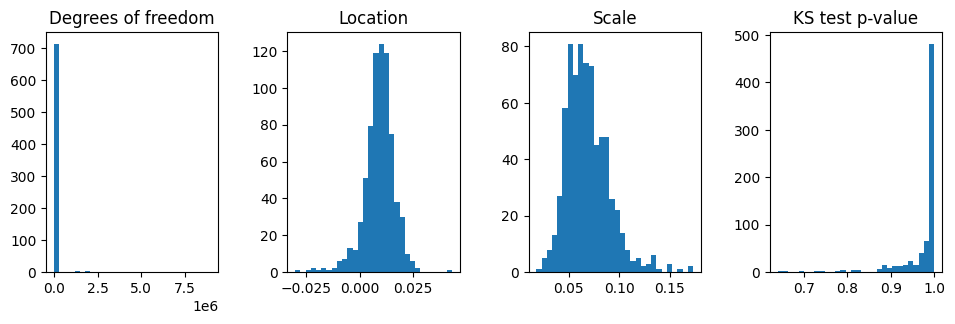

In [16]:
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4)

ax1.hist(company_stats["DoF"], bins=30)
ax1.set_title("Degrees of freedom")
ax2.hist(company_stats["Location"], bins=30)
ax2.set_title("Location")
ax3.hist(company_stats["Scale"], bins=30)
ax3.set_title("Scale")
ax4.hist(company_stats["KS p-value"], bins=30)
ax4.set_title("KS test p-value")

plt.subplots_adjust(left=0,
                bottom=0.1,
                right=1.4,
                top=0.6,
                wspace=0.4,
                hspace=0.3)
plt.show()

# Compare to index

We seek to provide insight on whether the sample from CDP is representative of major indices. Note that we don't have market capitalization data, thus, it's difficult to obtain comparable results, and this section should be taken with a grain of salt!

First, we separate data of individual countries:

In [15]:
all_companies = drop_neg.copy().iloc[:,:-len(index_tickers)].transpose()
all_companies["stock_symbol"] = [ ticker[ticker.find(".")+1:] if ticker.find(".")>0 else "" for ticker in all_companies.index ]
fin = all_companies[all_companies["stock_symbol"] == "HE"].transpose().drop("stock_symbol")
swe = all_companies[all_companies["stock_symbol"] == "ST"].transpose().drop("stock_symbol")
fra = all_companies[all_companies["stock_symbol"] == "PA"].transpose().drop("stock_symbol")
ger = all_companies[all_companies["stock_symbol"] == "BE"].transpose().drop("stock_symbol") # note small number of values, caused by missing data
uk = all_companies[all_companies["stock_symbol"] == "L"].transpose().drop("stock_symbol")
us = all_companies[all_companies["stock_symbol"] == ""].transpose().drop("stock_symbol")
sw = all_companies[all_companies["stock_symbol"] == "SW"].transpose().drop("stock_symbol")

If we want to use the original data with not all NaNs removed:

In [16]:
#fin = pd.read_csv("Data/Market price data/Monthly (EUR)/Finland.csv", index_col=0)
#us = pd.read_csv("Data/Market price data/Monthly (EUR)/United States.csv", index_col=0)
#fra = pd.read_csv("Data/Market price data/Monthly (EUR)/France.csv", index_col=0)
#ger = pd.read_csv("Data/Market price data/Monthly (EUR)/Germany.csv", index_col=0).transpose()
#uk = pd.read_csv("Data/Market price data/Monthly (EUR)/United Kingdom.csv", index_col=0)
#ger

Define functions for calculating an index of companies:

In [19]:
# Creates an index where the weights are equalized at each time step
def equal_weight_index(data): # dates in rows, companies in columns
    datecount, n = data.shape
    equal_weighted = data.copy()
    equal_weighted.iloc[0,:] = np.repeat(1, n)
    for j in range(1, datecount):
        date_weights = equal_weighted.iloc[j-1,:] * data.iloc[j,:] / data.iloc[j-1,:]
        equal_weighted.iloc[j,:] = np.repeat(date_weights.mean(), n)
    return equal_weighted.transpose().mean()

# Creates a price-weighted index, where the initial weights (at time instance "compare_to") are the prices of individual stocks
def price_index(country, compare_to):
    monthly_mean = country.transpose().mean()
    initial_price = monthly_mean[compare_to]
    return monthly_mean / initial_price

# Creates an index with equal weights, without rebalancing (an equal amount is invested to each company at time instance "compare_to")
def unweighted_index_std(prices, compare_to): # Companies in rows, dates in columns
    divisors = prices.iloc[:,compare_to]
    unweighted = prices.copy()
    unweighted = (unweighted.transpose() / divisors).transpose()
    unweighted = unweighted.sum()
    return unweighted / unweighted[compare_to]

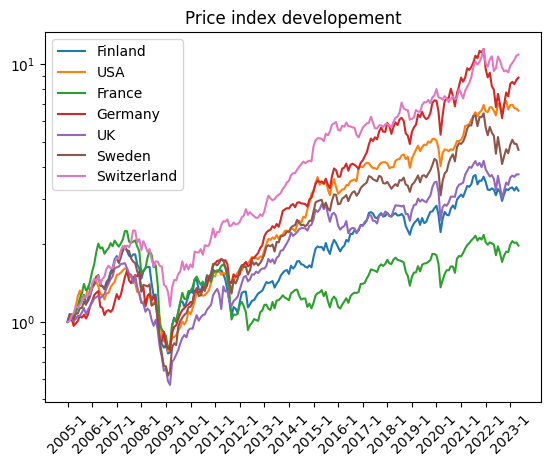

In [20]:
compare_to = 0
for data in [fin, us, fra, ger, uk, swe, sw]:
    plt.plot(price_index(data, compare_to))

plt.yscale("log")
plt.legend(["Finland","USA","France","Germany","UK","Sweden","Switzerland","Switzerland"])
plt.title("Price index developement")
plt.xticks(np.arange(0,all_companies.shape[1]+1,12))
plt.tick_params(axis='x', labelrotation = 45)

plt.show()

Visualization of the rebalanced equal-weighted index:

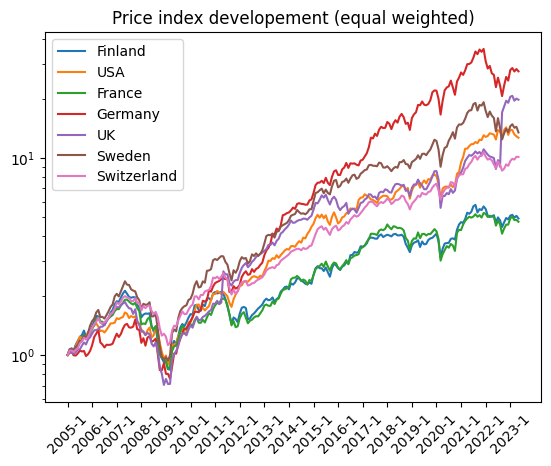

In [28]:
for data in [fin, us, fra, ger, uk, swe, sw]:
    plt.plot(equal_weight_index(data))

plt.yscale("log")
plt.legend(["Finland","USA","France","Germany","UK","Sweden","Switzerland"])
plt.title("Price index developement (equal weighted)")
plt.xticks(np.arange(0,all_companies.shape[1]+1,12))
plt.tick_params(axis='x', labelrotation = 45)

plt.show()

### Compare to the market indexes

List of available index tickers (correspond to S&P 500, CAC 40, OMX Stockholm 30, OMX Helsinki 25, DAX, FTSE 100, SMI):

In [22]:
index_tickers

['^GSPC', '^FCHI', '^OMX', '^OMXH25', '^GDAXI', '^FTSE', '^SSMI']

In [23]:
# Return logarithmic prices of the desired ticker
def index_log(ticker):
    index_price = dataframe[ticker].transpose()
    return np.log(index_price)

# Normalize the index by dividing it by the value at time instance "compare_to"
def index_index(ticker, compare_to):
    index_price = dataframe[ticker]
    first_value = index_price[compare_to]
    return index_price / first_value

# Same as above, but pass the series itself as a variable, instead of using the dataframe defined previously
def series_index(series, compare_to):
    first_value = series[compare_to]
    return series / first_value

Here is a visual comparison of the country's market index and company prices. Price-weighting (normalized mean of stock prices) is used for the companies.

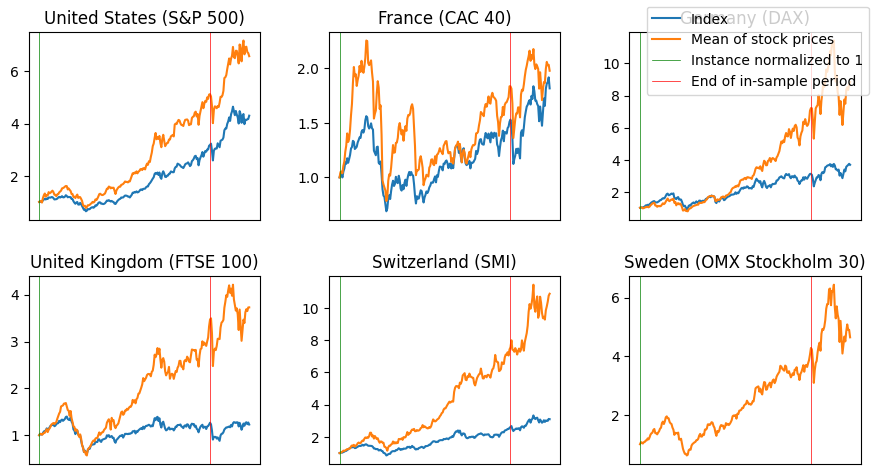

In [24]:
compare_to_date = '2005-1'
draw_vline_at = '2019-12'

compare_to = list(all_companies.columns).index(compare_to_date)
vline_loc = list(all_companies.columns).index(draw_vline_at)
fig, [(ax1,ax2,ax3),(ax4,ax5,ax6)] = plt.subplots(2,3)
ax1.plot(index_index("^GSPC", compare_to))
ax1.plot(price_index(us, compare_to))
# ax1.plot(unweighted_index(us.transpose(), compare_to))
ax1.set_title("United States (S&P 500)")
ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1.axvline(compare_to, color='green', linewidth=0.5)
ax1.axvline(vline_loc, color='red', linewidth=0.5)

ax2.plot(index_index("^FCHI", compare_to))
ax2.plot(price_index(fra, compare_to))
# ax2.plot(equal_weight_index(fra))
# ax2.plot(unweighted_index_std(fra.transpose(), compare_to))
ax2.set_title("France (CAC 40)")
ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax2.axvline(compare_to, color='green', linewidth=0.5)
ax2.axvline(vline_loc, color='red', linewidth=0.5)

ax3.plot(index_index("^GDAXI", compare_to))
ax3.plot(price_index(ger, compare_to))
# ax3.plot(unweighted_index(ger.transpose(), compare_to))
ax3.set_title("Germany (DAX)")
ax3.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax3.axvline(compare_to, color='green', linewidth=0.5)
ax3.axvline(vline_loc, color='red', linewidth=0.5)

ax4.plot(index_index("^FTSE", compare_to))
ax4.plot(price_index(uk, compare_to))
# ax4.plot(equal_weight_index(uk))
ax4.set_title("United Kingdom (FTSE 100)")
ax4.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax4.axvline(compare_to, color='green', linewidth=0.5)
ax4.axvline(vline_loc, color='red', linewidth=0.5)

ax5.plot(index_index("^SSMI", compare_to))
ax5.plot(price_index(sw, compare_to))
# ax5.plot(unweighted_index(fin.transpose(), compare_to))
ax5.set_title("Switzerland (SMI)")
ax5.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax5.axvline(compare_to, color='green', linewidth=0.5)
ax5.axvline(vline_loc, color='red', linewidth=0.5)

ax6.plot(index_index("^OMX", compare_to))
ax6.plot(price_index(swe, compare_to))
# ax6.plot(unweighted_index(swe.transpose(), compare_to))
ax6.set_title("Sweden (OMX Stockholm 30)")
ax6.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax6.axvline(compare_to, color='green', linewidth=0.5)
ax6.axvline(vline_loc, color='red', linewidth=0.5)

fig.legend(["Index","Mean of stock prices", "Instance normalized to 1", "End of in-sample period"])

plt.subplots_adjust(left=0,
                bottom=0.1,
                right=1.3,
                top=1,
                wspace=0.3,
                hspace=0.3)
plt.show()

Add the rebalanced equal weighted index to the comparison:

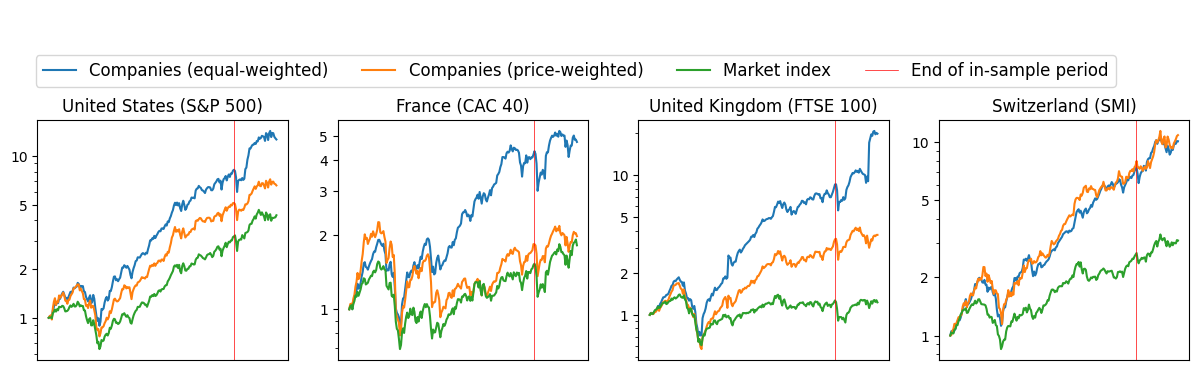

In [25]:
compare_to_date = '2005-1'
draw_vline_at = '2019-12'

compare_to = list(all_companies.columns).index(compare_to_date)
vline_loc = list(all_companies.columns).index(draw_vline_at)
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4)
ax1.plot(series_index(equal_weight_index(us), compare_to))
ax1.plot(price_index(us, compare_to))
ax1.plot(index_index("^GSPC", compare_to))
# ax1.plot(unweighted_index(us.transpose(), compare_to))
ax1.set_title("United States (S&P 500)")
ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
# ax1.axvline(compare_to, color='green', linewidth=0.5)
ax1.axvline(vline_loc, color='red', linewidth=0.5)
ax1.set_yscale("log")
ax1.set_yticks([1,2,5,10], [1,2,5,10], minor=False)

ax2.plot(series_index(equal_weight_index(fra), compare_to))
ax2.plot(price_index(fra, compare_to))
ax2.plot(index_index("^FCHI", compare_to))
# ax2.plot(unweighted_index_std(fra.transpose(), compare_to))
ax2.set_title("France (CAC 40)")
ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
# ax2.axvline(compare_to, color='green', linewidth=0.5)
ax2.axvline(vline_loc, color='red', linewidth=0.5)
ax2.set_yscale("log"); ax2.set_yticks([1,2,3,4,5], [1,2,3,4,5], minor=False)

ax3.plot(series_index(equal_weight_index(uk), compare_to))
ax3.plot(price_index(uk, compare_to))
ax3.plot(index_index("^FTSE", compare_to))
ax3.set_title("United Kingdom (FTSE 100)")
ax3.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
# ax3.axvline(compare_to, color='green', linewidth=0.5)
ax3.axvline(vline_loc, color='red', linewidth=0.5)
ax3.set_yscale("log"); ax3.set_yticks([1,2,5,10], [1,2,5,10], minor=False)

ax4.plot(series_index(equal_weight_index(sw), compare_to))
ax4.plot(price_index(sw, compare_to))
ax4.plot(index_index("^SSMI", compare_to))
# ax4.plot(unweighted_index(fin.transpose(), compare_to))
ax4.set_title("Switzerland (SMI)")
ax4.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
# ax4.axvline(compare_to, color='green', linewidth=0.5)
ax4.axvline(vline_loc, color='red', linewidth=0.5)
ax4.set_yscale("log"); ax4.set_yticks([1,2,5,10], [1,2,5,10], minor=False)


fig.legend(["Companies (equal-weighted)", "Companies (price-weighted)", "Market index", "End of in-sample period"], loc=(0.03,0.765), prop={'size':12}, ncol=4)

plt.subplots_adjust(left=0,
                bottom=0.1,
                right=1.8,
                top=0.6,
                wspace=0.2,
                hspace=0)
# plt.savefig("Pictures/Index_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

Plot the 4 major indexes

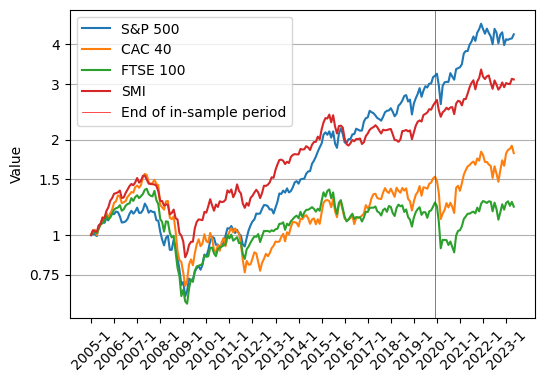

In [48]:
plt.figure(figsize=(6,4))
plt.plot(index_index("^GSPC", compare_to))
plt.plot(index_index("^FCHI", compare_to))
plt.plot(index_index("^FTSE", compare_to))
plt.plot(index_index("^SSMI", compare_to))
plt.axvline(list(all_companies.columns).index("2019-12"), color='red', linewidth=0.5)

plt.legend(["S&P 500", "CAC 40", "FTSE 100", "SMI", "End of in-sample period"])
plt.yscale("log")
plt.ylabel("Value")
plt.yticks([],minor=True); plt.yticks([0.75,1,1.5,2,3,4], [0.75,1,1.5,2,3,4], minor=False)
plt.grid(visible=True, which="major", axis="y")
plt.xticks(np.arange(0,log_prices.shape[0]+1,12))
plt.tick_params(axis='x', labelrotation = 45)
# plt.savefig("Pictures/Index_value.png", dpi=300, bbox_inches="tight")
plt.show()

We note that S&P 500 has shown much more rapid growth in recent years than the European indexes

## Aggregate all companies

In [28]:
company_prices = drop_neg.transpose().iloc[:-6,:]
price_weighted = company_prices.mean()

In [29]:
def unweighted_index(prices, compare_to): # Companies in rows, dates in columns
    divisors = prices.iloc[:,compare_to]
    unweighted = prices.copy()
    unweighted = (unweighted.transpose() / divisors).transpose()
    return unweighted.sum()

Index of all companies calculated with 3 different weighting schemas:

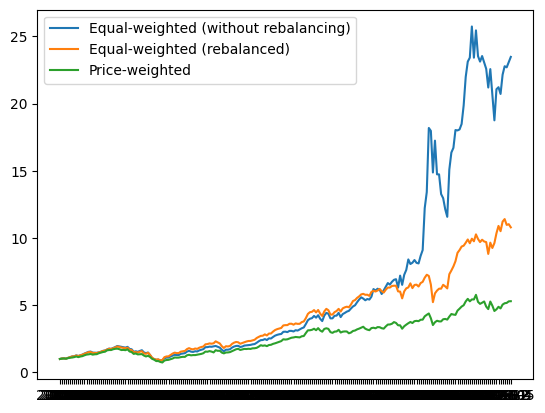

In [34]:
compare_to = 0

plt.plot(unweighted_index_std(company_prices, compare_to))
plt.plot(equal_weight_index(company_prices.transpose()))
plt.plot(price_index(company_prices.transpose(), compare_to))
#plt.plot(price_weighted/price_weighted[0])
#plt.plot(index_index("^GSPC", compare_to))
plt.legend(["Equal-weighted (without rebalancing)", "Equal-weighted (rebalanced)", "Price-weighted"])

plt.show()

Categorize the companies based on the calculated emission intensity (those below, and those above). Count the number of companies in each category.

In [35]:
financed_emissions2 = financed_emissions.loc[filtered_ticker_list2,:]
financed_emissions2.to_csv(f"{folderpath}/Emission_data.csv")

emission_median = financed_emissions2.describe().loc["50%", "Emission intensity (tCO2e/MEUR)"]
print(f"Median emission intensity: {emission_median} tCO2e/MEUR")
low_emis = financed_emissions2[financed_emissions2["Emission intensity (tCO2e/MEUR)"] < emission_median]
high_emis = financed_emissions2[financed_emissions2["Emission intensity (tCO2e/MEUR)"] >= emission_median]
low_emis.groupby("Industry").count()

Median emission intensity: 31.4733277482027 tCO2e/MEUR


,Country,Company Name,CDP Score,CE (tCO2e),Estimated EVIC (MEUR),Emission intensity (tCO2e/MEUR)
Industry,,,,,,
"Biotech, health care & pharma",41,41,41,41,41,41
"Food, beverage & agriculture",8,8,8,8,8,8
Hospitality,8,8,8,8,8,8
Infrastructure,30,30,30,30,30,30
Manufacturing,54,54,54,54,54,54
Materials,6,6,6,6,6,6
Retail,17,17,17,17,17,17
Services,198,198,198,198,198,198


In [36]:
high_emis.groupby("Industry").count()

,Country,Company Name,CDP Score,CE (tCO2e),Estimated EVIC (MEUR),Emission intensity (tCO2e/MEUR)
Industry,,,,,,
Apparel,2,2,2,2,2,2
"Biotech, health care & pharma",20,20,20,20,20,20
"Food, beverage & agriculture",29,29,29,29,29,29
Fossil Fuels,15,15,15,15,15,15
Hospitality,11,11,11,11,11,11
Infrastructure,25,25,25,25,25,25
Manufacturing,83,83,83,83,83,83
Materials,51,51,49,51,51,51
Power generation,12,12,12,12,12,12


Low emission category does not include any companies from the following industries: Apparel, Fossil Fuels, Power generation, Transportation services. High emisswion category includes companies from all 12 industries.

An additional variate is whether the companies have quantified emission reduction targets in the CDP questionnaire.

In [39]:
quantified_target_companies = pd.read_csv("Data/Emissions/Companies_with_reduction_targets_2020.csv", sep=";", header=None)[4]
quantified_target_companies = company_prices.index.intersection(pd.Index(quantified_target_companies))
pd.DataFrame(quantified_target_companies).to_csv(f"{folderpath}/Quantified_target_company_tickers.csv")
quantified_target_company_prices = company_prices.loc[quantified_target_companies,:]
quant_unweighted = unweighted_index_std(quantified_target_company_prices, 0)
quant_price_weighted = price_index(quantified_target_company_prices.transpose(), compare_to)
quantified_target_companies

Index(['OMV.VI', 'PAL.VI', 'TKA.VI', 'VER.VI', 'VOE.VI', 'PROX.BR', 'SOLB.BR',
       'UCB.BR', 'DANSKE.CO', 'DNORD.CO',
       ...
       'REG', 'RF', 'RSG', 'SCHN', 'SLB', 'SO', 'TXN', 'UNH', 'UNM', 'UPS'],
      dtype='object', length=226)

This includes 226 companies out of the 724 studied.

Obtain the company prices in lower and higher emission intensities:

In [44]:
low_emis_prices = company_prices.loc[low_emis.index.to_numpy(),:]
low_emis_index_log = np.log(unweighted_index(low_emis_prices, 0))
high_emis_prices = company_prices.loc[high_emis.index.to_numpy(),:]
high_emis_index_log = np.log(unweighted_index(high_emis_prices, 0))

Plot the price-weighted index of company prices in different categories:

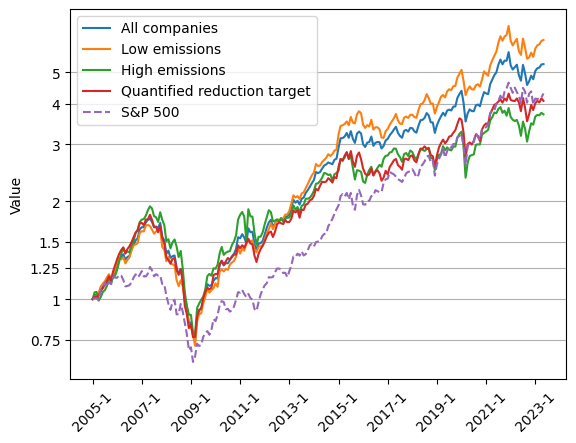

In [46]:
compare_to = 0

plt.plot(price_index(company_prices.transpose(), compare_to))
plt.plot(price_index(low_emis_prices.transpose(), compare_to))
plt.plot(price_index(high_emis_prices.transpose(), compare_to))
plt.plot(price_index(quantified_target_company_prices.transpose(), compare_to))
plt.plot(index_index("^GSPC", compare_to), ls="--")
# plt.plot(index_index("^SSMI", compare_to), ls="--")
# plt.plot(index_index("^FCHI", compare_to), ls="--")

plt.legend(["All companies", "Low emissions", "High emissions", "Quantified reduction target", "S&P 500"])
plt.yscale("log")
plt.ylabel("Value")
plt.yticks([],minor=True); plt.yticks([0.75,1,1.25,1.5,2,3,4,5], [0.75,1,1.25,1.5,2,3,4,5], minor=False)
plt.grid(visible=True, which="major", axis="y")
plt.xticks(np.arange(0,company_prices.shape[1]+1,24))
plt.tick_params(axis='x', labelrotation = 45)

plt.savefig("Pictures/Category_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

Plot the equal-weighted index of company prices in different categories:

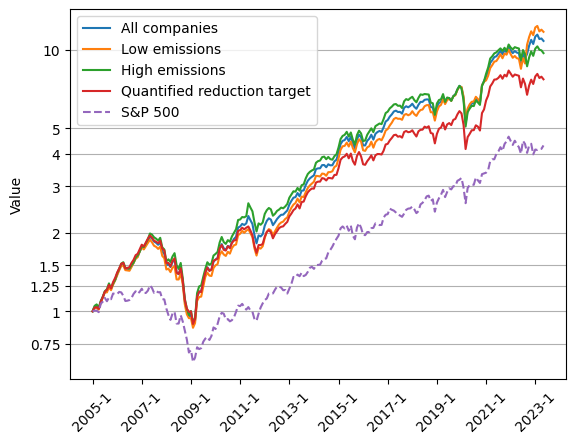

In [72]:
compare_to = 0

plt.plot(equal_weight_index(company_prices.transpose()))
plt.plot(equal_weight_index(low_emis_prices.transpose()))
plt.plot(equal_weight_index(high_emis_prices.transpose()))
plt.plot(equal_weight_index(quantified_target_company_prices.transpose()))
plt.plot(index_index("^GSPC", compare_to), ls="--")
# plt.plot(index_index("^SSMI", compare_to), ls="--")
# plt.plot(index_index("^FCHI", compare_to), ls="--")

plt.legend(["All companies", "Low emissions", "High emissions", "Quantified reduction target", "S&P 500"])
plt.yscale("log")
plt.ylabel("Value")
plt.yticks([],minor=True); plt.yticks([0.75,1,1.25,1.5,2,3,4,5,10], [0.75,1,1.25,1.5,2,3,4,5,10], minor=False)
plt.grid(visible=True, which="major", axis="y")
plt.xticks(np.arange(0,company_prices.shape[1]+1,24))
plt.tick_params(axis='x', labelrotation = 45)

# plt.savefig("Pictures/Category_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

Different weightings side by side:

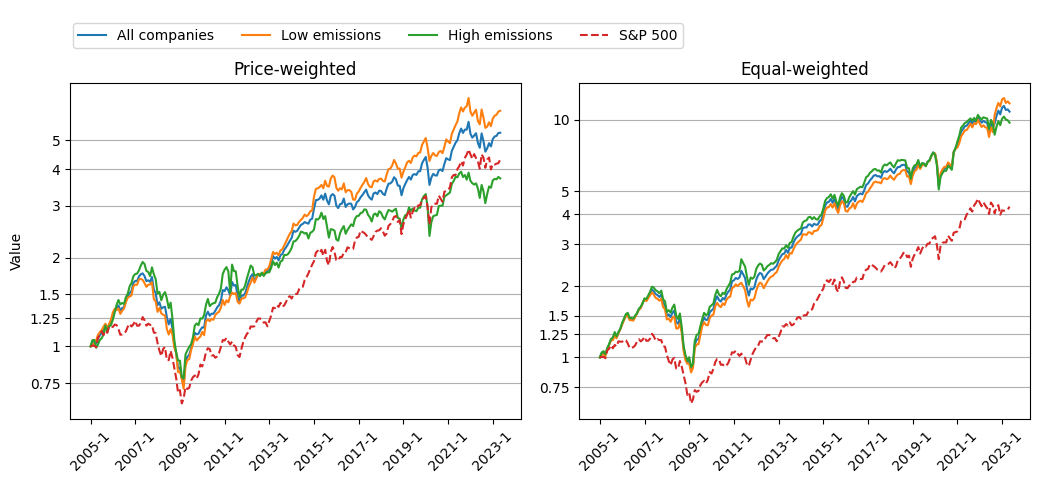

In [106]:
compare_to = 0

fig, [ax1, ax2] = plt.subplots(1, 2)


ax1.plot(price_index(company_prices.transpose(), compare_to))
ax1.plot(price_index(low_emis_prices.transpose(), compare_to))
ax1.plot(price_index(high_emis_prices.transpose(), compare_to))
ax1.plot(index_index("^GSPC", compare_to), ls="--")

ax1.set_yscale("log")
ax1.set_ylabel("Value")
ax1.set_yticks([],minor=True); ax1.set_yticks([0.75,1,1.25,1.5,2,3,4,5], [0.75,1,1.25,1.5,2,3,4,5], minor=False)
ax1.grid(visible=True, which="major", axis="y")
ax1.set_xticks(np.arange(0,company_prices.shape[1]+1,24))
ax1.tick_params(axis='x', labelrotation = 45)
ax1.set_title("Price-weighted")

ax2.plot(equal_weight_index(company_prices.transpose()))
ax2.plot(equal_weight_index(low_emis_prices.transpose()))
ax2.plot(equal_weight_index(high_emis_prices.transpose()))
ax2.plot(index_index("^GSPC", compare_to), ls="--")

ax2.set_yscale("log")
ax2.set_yticks([],minor=True); ax2.set_yticks([0.75,1,1.25,1.5,2,3,4,5,10], [0.75,1,1.25,1.5,2,3,4,5,10], minor=False)
ax2.grid(visible=True, which="major", axis="y")
ax2.set_xticks(np.arange(0,company_prices.shape[1]+1,24))
ax2.tick_params(axis='x', labelrotation = 45)
ax2.set_title("Equal-weighted")

fig.legend(["All companies", "Low emissions", "High emissions", "S&P 500"], loc=(0.07,0.9), prop={'size':10}, ncol=4)

plt.subplots_adjust(left=0,
                bottom=0.1,
                right=1.5,
                top=0.8,
                wspace=0.13,
                hspace=0)

plt.savefig("Pictures/Category_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

The used weighting affects the order of the categories. In price-weighting, individual companies can drag the value down while in equal-weighted index, we see explosive growth likely caused a small amount of companies that were very minor in the beginning of the period. Market cap based weighting should be used instead to align with the market indexes and provide more robust and reliable results.